# ML4SCI 2021: NMR Challenge

Author: Tun Sheng Tan

Overview:  Two stage predictions

    Stage 1 -> Using three models (LGBM, Transformer 1,  Transformer 2) with features: Fourier transform + Constant-Q transform + Trig
    Stage 2 -> Using linear regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import warnings

from nnAudio.Spectrogram import CQT1992v2
from os import path
from scipy.fft import fft, ifft, fftshift, ifftshift
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge, LinearRegression
from lightgbm import LGBMRegressor

from torch import nn, optim
from torch.nn import functional as F
from skorch.callbacks import LRScheduler
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping

warnings.filterwarnings('ignore') 

# Helper

In [2]:
class LambdaScaler(BaseEstimator, TransformerMixin):
    """
    Custom scaler transformer that takes in a function
    There is no way to stack lambda function and scaler
    for target in sklearn.
    """
    def __init__(self, scaler=StandardScaler(), func=None, inverse_func=None):
        self.scaler = scaler
        self.func = func
        self.inverse_func = inverse_func
        return None

    def fit(self, X, y=None):
        if self.func and self.inverse_func:
            self.scaler.fit(self.func(X))
        else:
            self.scaler.fit(X)
        return self

    def transform(self, X, y=None):
        if self.func and self.inverse_func:
            return self.scaler.transform(self.func(X))
        else:
            return self.scaler.transform(X)

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X, y=None):
        if self.func and self.inverse_func:
            return self.inverse_func(self.scaler.inverse_transform(X))
        else:
            return self.scaler.inverse_transform(X)

# Feature Engineering

In [3]:
def load_dataset(train=True):
    """
    Loads dataset
    """
    configuration = {
        'path': './Dataset',
        'train': { # 3000 samples, length 856
            'target': 'mat_info.txt', # ['a_x', 'a_z', 'theta']
            'x1': 'echos_r.txt',
            'x2': 'echos_i.txt',
        },
        'test': {
            'x1': 'submit_echos_r.txt',
            'x2': 'submit_echos_i.txt'
        }
    }
    
    if train:
        x1 = np.loadtxt(path.join(configuration['path'], configuration['train']['x1']))
        x2 = np.loadtxt(path.join(configuration['path'], configuration['train']['x2']))
        feature = np.stack((x1, x2), axis=1) # (n, feature, length)
        target = np.loadtxt(path.join(configuration['path'], configuration['train']['target'])) # (n, 3)
        return feature, target
    else:
        x1 = np.loadtxt(path.join(configuration['path'], configuration['test']['x1']))
        x2 = np.loadtxt(path.join(configuration['path'], configuration['test']['x2']))
        feature = np.stack((x1, x2), axis=1) # (n, feature, length)
        return feature

def engineer_gradients(X, order=1):
    """
    Computes the gradient of magnetic filed up to order N
    """
    new_features = []
    for i in range(order):
        if i == 0:
            new_features.append(np.gradient(X[:,-2], axis=1)[:,np.newaxis,:])
            new_features.append(np.gradient(X[:,-1], axis=1)[:,np.newaxis,:])
        else:
            new_features.append(np.gradient(new_features[-2], axis=2))
            new_features.append(np.gradient(new_features[-1], axis=2))
    new_features = np.concatenate(tuple(new_features), axis=1)
    return new_features

def engineer_mz(X, sigma=1.1):
    """
    Computes trigonometry + log transform for Mxy
    """
    nsample, nfeature, length = X.shape
    field = np.zeros([nsample, 2, length])
    for i in range(nsample):
        # Compute magnitude of M field
        M = sigma*np.max(np.sqrt(X[i,0,:]**2 + X[i,1,:]**2))

        # Compute azimuthal and polar angles
        phi = np.arctan(X[i,1,:]/X[i,0,:])
        theta = np.arcsin(X[i,0,:]/(M*np.cos(phi)))

        # Found that using the log gives better performance
        field[i,0,:] = np.log(M*np.cos(theta))
        field[i,1,:] = np.log(abs(theta))
    return field

def engineer_fft(X, order=0):
    """
    Computes Fourier transform and its derivative for Mxy
    """
    t0 = 20*1e-6
    omega = 100*1e3
    tau = 100*1e-6
    t = np.linspace(130, 270, 856)*1e-6
    g = lambda t: 1/(( 1 + np.exp(-omega*(t0+(t-2*tau))) ) * ( 1 + np.exp(-omega*(t0-(t-2*tau))) ))

    L = t[-1]-t[0]
    n = len(t)
    m = 32
    kappa = 2*np.pi/L * np.arange(-n/2, n/2) /1e6
    raw = X[:,0] + 1j*X[:,1]
    signal = np.pad(g(t)*raw, [(0,0), (m, m)])
    fs = fftshift(fft(fftshift(signal)))[:,np.newaxis,m:-m]
    freq = np.zeros([len(X), 1, X.shape[-1]])
    freq[:,0,:] = np.tile(kappa+10, (len(X), 1))
    new_feature = np.abs(fs)
    for _ in range(order):
        x1 = np.gradient(new_feature[:,-1,:], axis=1)[:,np.newaxis,:]
        new_feature = np.concatenate((new_feature, x1), axis=1)

    return new_feature

def engineer_cqt(X):
    """
    Computes constant-Q transform for Mxy
    """
    t0 = 20*1e-6
    omega = 100*1e3
    tau = 100*1e-6
    t = np.linspace(130, 270, 856)*1e-6
    g = lambda t: 1/(( 1 + np.exp(-omega*(t0+(t-2*tau))) ) * ( 1 + np.exp(-omega*(t0-(t-2*tau))) ))

    L = t[-1]-t[0]
    n = len(t)
    m = 32
    raw = X[:,0] + 1j*X[:,1]
    signal = np.pad(g(t)*raw, [(0,0), (m, m)])

    wave_transform = CQT1992v2(sr=600, fmin=10, fmax=200, hop_length=8)
    waves = torch.from_numpy(np.abs(signal)).float()
    cqtgram = wave_transform(waves).numpy()
    return cqtgram

In [4]:
TARGETS = ['a_x', 'a_z', 'theta']

# Light Gradient Boosting Machine (LGBM)

In [5]:
models = { 
 'a_x': {
      'features': {'mz': {}, 'fft': { 'order': 1 }, 'cqt': {}},
      'regressor': LGBMRegressor(random_state=1),
      'type': 'lgbm',
 },
 'a_z': {
      'features': {'mz': {}, 'fft': { 'order': 1 }, 'cqt': {}},
      'regressor': LGBMRegressor(random_state=1),
      'type': 'lgbm',
 },
 'theta': {
      'features': {'mz': {}, 'fft': { 'order': 1 }},
      'regressor': LGBMRegressor(random_state=1),
      'type': 'lgbm',
 }
}

In [6]:
X, Y = load_dataset(train=True)
nsamples = X.shape[0]

X_sub = load_dataset(train=False)
nsamples_sub = X_sub.shape[0]
submission = pd.DataFrame(data=np.zeros([nsamples_sub, 3]), columns=TARGETS)

In [7]:
splits = 10
total_error = 0
oof_preds = np.zeros((nsamples, 3))

for i, target in enumerate(TARGETS):
    print(f"\nTraining for {target}...")
    skf = KFold(n_splits=splits, shuffle=True, random_state=2021)
    model_preds = 0

    # Construct features
    model = models[target]
    features = []
    features_sub = []
    if 'timeseries' in model['features']:
        features.append(X.reshape([nsamples, -1]))
        features_sub.append(X_sub.reshape([nsamples_sub, -1]))
    if 'gradient' in model['features']:
        order = model['features']['gradient']['order']
        features.append(engineer_gradients(X, order=order).reshape([nsamples, -1]))
        features_sub.append(engineer_gradients(X_sub, order=order).reshape([nsamples_sub, -1]))
    if 'mz' in model['features']:
        features.append(engineer_mz(X).reshape([nsamples, -1]))
        features_sub.append(engineer_mz(X_sub).reshape([nsamples_sub, -1]))
    if 'fft' in model['features']:
        fft_order = model['features']['fft']['order']
        features.append(engineer_fft(X, fft_order).reshape([nsamples, -1]))
        features_sub.append(engineer_fft(X_sub, fft_order).reshape([nsamples_sub, -1]))
    if 'cqt' in model['features']:
        features.append(engineer_cqt(X).reshape([nsamples, -1]))
        features_sub.append(engineer_cqt(X_sub).reshape([nsamples_sub, -1]))
    features = np.concatenate(tuple(features), axis=1)
    features_sub = np.concatenate(tuple(features_sub), axis=1)

    # Iterate over each fold and make prediction
    for num, (train_idx, valid_idx) in enumerate(skf.split(features, Y)):
        X_train, X_valid = features[train_idx], features[valid_idx]
        y_train, y_valid = Y[train_idx,i], Y[valid_idx,i]
        
        pipe = Pipeline([ ('scaler', StandardScaler()),
                          ('regressor', model['regressor']) ])

        m = TransformedTargetRegressor(
                regressor=pipe,
                transformer=LambdaScaler(scaler=StandardScaler(), func=np.log, inverse_func=np.exp))

        m.fit(X_train, y_train)
        
        # Making prediction for submission by averaging over all folds aka test set
        model_preds += m.predict(features_sub) / splits
        
        # Compute validation set
        oof_preds[valid_idx, i] = m.predict(X_valid)
        print(f"Fold {num} MSE: {mean_squared_error(y_valid, oof_preds[valid_idx, i])}")
    print(f"\nOverall MSE: {mean_squared_error(Y[:,i], oof_preds[:,i])}")  
    total_error += mean_squared_error(Y[:,i], oof_preds[:,i])
    submission[target] = model_preds

print("Total error = {:.5f}".format(total_error))

if False:
    print("Upper bound")
    print(np.sum(submission['a_x']>150), np.sum(submission['a_z']>300), np.sum(submission['theta']>90))

    print("Lower bound")
    print(np.sum(submission['a_x']<0), np.sum(submission['a_z']<0), np.sum(submission['theta']<10))

submission['a_x'] = np.clip(submission['a_x'], 0, 150)
submission['a_z'] = np.clip(submission['a_z'], 0, 300)
submission['theta'] = np.clip(submission['theta'], 10, 90)

oof_preds = pd.DataFrame(oof_preds, columns=TARGETS)
if False:
    print("Upper bound")
    print(np.sum(oof_preds['a_x']>150), np.sum(oof_preds['a_z']>300), np.sum(oof_preds['theta']>90))

    print("Lower bound")
    print(np.sum(oof_preds['a_x']<0), np.sum(oof_preds['a_z']<0), np.sum(oof_preds['theta']<10))

oof_preds['a_x'] = np.clip(oof_preds['a_x'], 0, 150)
oof_preds['a_z'] = np.clip(oof_preds['a_z'], 0, 300)
oof_preds['theta'] = np.clip(oof_preds['theta'], 10, 90)

submission.to_csv('submitted_lgbm.txt', sep=' ', header=False, index=False, float_format='%.18e')
oof_preds.to_csv(f'oof_lgbm.txt', sep=' ', header=False, index=False, float_format='%.18e')


Training for a_x...
CQT kernels created, time used = 0.0408 seconds
CQT kernels created, time used = 0.0056 seconds
Fold 0 MSE: 26.68357040327377
Fold 1 MSE: 31.71459914709434
Fold 2 MSE: 33.57703778700797
Fold 3 MSE: 33.06744895746877
Fold 4 MSE: 28.756579339598684
Fold 5 MSE: 59.48186931196433
Fold 6 MSE: 40.884155872730844
Fold 7 MSE: 38.417260361388074
Fold 8 MSE: 34.13495818154241
Fold 9 MSE: 35.586632213015804

Overall MSE: 36.2304111575085

Training for a_z...
CQT kernels created, time used = 0.0041 seconds
CQT kernels created, time used = 0.0043 seconds
Fold 0 MSE: 2439.120091458019
Fold 1 MSE: 2119.6453140590734
Fold 2 MSE: 2028.0889613085853
Fold 3 MSE: 2610.296714512421
Fold 4 MSE: 2400.9739306852966
Fold 5 MSE: 2726.791328413256
Fold 6 MSE: 2236.594168413584
Fold 7 MSE: 2054.684365347946
Fold 8 MSE: 2513.4587760355776
Fold 9 MSE: 1869.0630678170787

Overall MSE: 2299.8716718050837

Training for theta...
Fold 0 MSE: 1.186671828674066
Fold 1 MSE: 1.2183641025533993
Fold 2 MS

# Prediction Range

$α_x$: coupling strength $\in$ [0, 150] kHz

$α_z$: coupling strength $\in$ [0, 300] kH

$\theta$: flip angle $\in$ [10,90] $^\circ$

# Transformer Model

In [8]:
class MyTransformer(nn.Module):
    def __init__(self, in_channel, d_model=856, nhead=8, dim_feedforward=2048, dropout=0.1, cqt_shape=None):
        super(MyTransformer, self).__init__()
        self.in_channel = in_channel
        self.d_model = d_model
        self.d_hidden = nhead*25
        self.nhead = nhead
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout
        self.cqt_shape = cqt_shape

        self.proj = nn.Sequential(
            nn.Linear(self.d_model*self.in_channel, 600*self.in_channel),
            nn.SiLU(),
            nn.Linear(600*self.in_channel, self.in_channel*self.d_hidden),
        ) 
        
        self.proj_cqt = nn.Sequential(
            nn.Linear(self.cqt_shape, 600),
            nn.SiLU(),
            nn.Linear(600, self.d_hidden),
        )

        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.d_hidden, 
            nhead=nhead,  # Must be divide d_model
            dim_feedforward=dim_feedforward, 
            activation=nn.SiLU(),
            dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        
        self.regressor = nn.Sequential(
            nn.Linear(self.d_hidden*(self.in_channel+1), self.d_hidden),
            nn.SiLU(),
            nn.Linear(self.d_hidden, 3)
        )

    def forward(self, x, **kwargs):
        xp = self.proj(x[:,:-self.cqt_shape]).view(-1, self.in_channel, self.d_hidden)
        xt = self.proj_cqt(x[:,-self.cqt_shape:]).view(-1, 1, self.d_hidden)
        x = torch.cat((xp, xt), axis=1)
        x = self.transformer_encoder(x)
        x = torch.flatten(x, start_dim=1)
        x = self.regressor(x)
        return x

def load_transformer(in_channel=12, nhead=8, d_model=856, cqt_shape=None,
                     dim_feedforward=2048, dropout=0.0, batch_size=256,
                     lr=0.2, max_epochs=1000, verbose=0, device='cuda'):
    net = NeuralNetRegressor(
        MyTransformer,
        module__in_channel=in_channel,
        module__d_model=d_model,
        module__nhead=nhead,
        module__cqt_shape=cqt_shape,
        module__dim_feedforward=dim_feedforward,
        module__dropout=dropout,
        batch_size=batch_size,
        max_epochs=max_epochs,
        optimizer=optim.SGD,
        lr=lr,
        criterion=nn.SmoothL1Loss,
        verbose=verbose,
        callbacks=[
            ( 'lr_scheduler',
                LRScheduler(
                    policy=optim.lr_scheduler.CyclicLR,
                    max_lr=1e-1,
                    base_lr=1e-10, #1e-5,
                    step_size_up=100,
                )
            ),
        ],
        iterator_train__shuffle=True,
    )
    net.set_params(device=device)
    return net

In [9]:
X, Y = load_dataset(train=True)
nsamples = X.shape[0]

X_sub = load_dataset(train=False)
nsamples_sub = X_sub.shape[0]

models = [
    {
        'features': {'mz': {}, 'fft': { 'order': 0 }, 'cqt': {}},
        'type': 'transformer',
    },
    {
        'features': {'mz': {}, 'fft': { 'order': 1 }, 'cqt': {}},
        'type': 'transformer',
    }
]

In [12]:
splits = 10
skf = KFold(n_splits=splits, shuffle=True, random_state=2021)

for kk in range(len(models)):
    submission = pd.DataFrame(data=np.zeros([nsamples_sub, 3]), columns=TARGETS)
    total_error = 0
    oof_preds = np.zeros((nsamples, 3))
    model_preds = 0
    
    # Construct features
    features = []
    features_sub = []
    
    model = models[kk]
    if 'timeseries' in model['features']:
        features.append(X)
        features_sub.append(X_sub)
    if 'gradient' in model['features']:
        order = model['features']['gradient']['order']
        features.append(engineer_gradients(X, order=order))
        features_sub.append(engineer_gradients(X_sub, order=order))
    if 'mz' in model['features']:
        features.append(engineer_mz(X))
        features_sub.append(engineer_mz(X_sub))
    if 'fft' in model['features']:
        fft_order = model['features']['fft']['order']
        features.append(engineer_fft(X, fft_order))
        features_sub.append(engineer_fft(X_sub, fft_order))

    K = None
    ks = 0
    if 'cqt' in model['features']:
        K = engineer_cqt(X).reshape(nsamples, -1)
        ks = K.shape[1]
        K_sub = engineer_cqt(X_sub).reshape(nsamples_sub, -1)

    features = np.concatenate(tuple(features), axis=1)
    _, in_channel, seq_length = features.shape

    features = features.reshape(nsamples, -1)
    features_sub = np.concatenate(tuple(features_sub), axis=1).reshape(nsamples_sub, -1)

    features = np.concatenate((features, K), axis=1).astype('float32') 
    features_sub = np.concatenate((features_sub, K_sub), axis=1).astype('float32') 

    Y = Y.astype('float32')

    model['regressor'] = load_transformer(in_channel=in_channel, d_model=seq_length, cqt_shape=ks)

    # Iterate over each fold and make prediction
    for num, (train_idx, valid_idx) in enumerate(skf.split(features, Y)):
        X_train, X_valid = features[train_idx], features[valid_idx]
        y_train, y_valid = Y[train_idx], Y[valid_idx]
        model['regressor'].initialize()
        pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model['regressor'])
            ])

        m = TransformedTargetRegressor(
                regressor=pipe,
                transformer=LambdaScaler(scaler=StandardScaler(), func=np.log, inverse_func=np.exp))

        m.fit(X_train, y_train)

        # Making prediction for submission by averaging over all folds aka test set
        model_preds += m.predict(features_sub) / splits

        # Compute validation set
        oof_preds[valid_idx] = m.predict(X_valid)
        print(f"Fold {num} MSE:  {mean_squared_error(y_valid, oof_preds[valid_idx], multioutput='raw_values')} | {mean_squared_error(y_valid, oof_preds[valid_idx])}")

    print(f"\nOverall MSE: {mean_squared_error(Y, oof_preds, multioutput='raw_values')}") 
    
    total_error = mean_squared_error(Y, oof_preds)
    submission['a_x'] = model_preds[:,0]
    submission['a_z'] = model_preds[:,1]
    submission['theta'] = model_preds[:,2]
    oof_preds = pd.DataFrame(oof_preds, columns=TARGETS)

    print("Total error = {:.5f}".format(total_error))

    submission['a_x'] = np.clip(submission['a_x'], 0, 150)
    submission['a_z'] = np.clip(submission['a_z'], 0, 300)
    submission['theta'] = np.clip(submission['theta'], 10, 90)

    oof_preds['a_x'] = np.clip(oof_preds['a_x'], 0, 150)
    oof_preds['a_z'] = np.clip(oof_preds['a_z'], 0, 300)
    oof_preds['theta'] = np.clip(oof_preds['theta'], 10, 90)

    # Save to file
    submission.to_csv(f'submitted_transformer_{kk}.txt', sep=' ', header=False, index=False, float_format='%.18e')
    oof_preds.to_csv(f'oof_transformer_{kk}.txt', sep=' ', header=False, index=False, float_format='%.18e')

CQT kernels created, time used = 0.0047 seconds
CQT kernels created, time used = 0.0047 seconds
Fold 0 MSE:  [  33.9036887  2111.31408246    4.37978581] | 716.5325189899071
Fold 1 MSE:  [  39.2824819  2082.0491256     3.25663827] | 708.1960819247394
Fold 2 MSE:  [  42.47845908 2569.60671948    4.50844149] | 872.1978733502465
Fold 3 MSE:  [  28.7078264  2645.28191787    3.98292076] | 892.6575550105744
Fold 4 MSE:  [  32.17694108 2284.61873003    4.04153094] | 773.6124006817801
Fold 5 MSE:  [  51.82530554 2637.76794103    8.3256201 ] | 899.3062888879489
Fold 6 MSE:  [  43.89418325 2413.01278898    6.84388172] | 821.2502846495337
Fold 7 MSE:  [  58.39690989 2130.25212303    5.00586848] | 731.2183004664817
Fold 8 MSE:  [  34.72423954 2573.58522648    5.23238025] | 871.1806154212977
Fold 9 MSE:  [  54.96410681 1958.90619416    5.5745023 ] | 673.1482677571892

Overall MSE: [  42.03541422 2340.63948491    5.11515701]
Total error = 795.93002
CQT kernels created, time used = 0.0049 seconds
CQT 

# Stacking

Combine prediction from base models by  linear combination.

==a_x===
Fold 0
  Model 0 = Train : 37.98824, Valid:  29.18016
  Model 1 = Train : 41.63200, Valid:  34.02451
  Model 2 = Train : 48.62701, Valid:  38.41691
  Meta-Model = Train : 26.92693,  Valid : 20.55928
Fold 1
  Model 0 = Train : 36.95272, Valid:  33.32224
  Model 1 = Train : 41.33180, Valid:  35.22533
  Model 2 = Train : 47.01929, Valid:  44.84778
  Meta-Model = Train : 26.14781,  Valid : 23.66088
Fold 2
  Model 0 = Train : 34.25348, Valid:  44.11922
  Model 1 = Train : 39.76600, Valid:  41.48852
  Model 2 = Train : 46.63997, Valid:  46.36507
  Meta-Model = Train : 24.93635,  Valid : 28.61814
Fold 3
  Model 0 = Train : 35.37061, Valid:  39.65071
  Model 1 = Train : 38.57461, Valid:  46.25407
  Model 2 = Train : 45.76064, Valid:  49.88241
  Meta-Model = Train : 25.05109,  Valid : 28.05411
Fold 4
  Model 0 = Train : 36.56808, Valid:  34.86080
  Model 1 = Train : 39.24811, Valid:  43.56008
  Model 2 = Train : 44.87804, Valid:  53.41279
  Meta-Model = Train : 25.07151,  Valid : 28.00

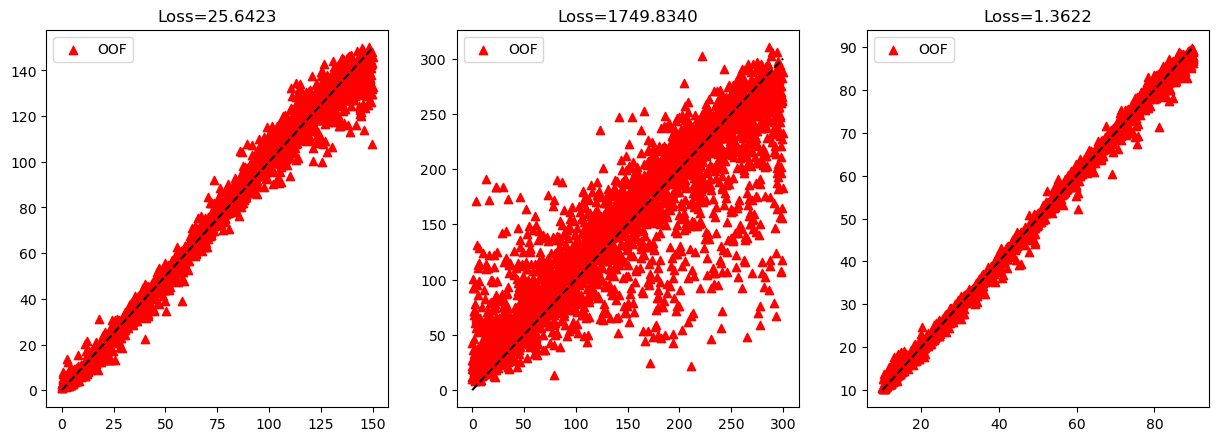


Overall error = 1776.8384591271233


In [26]:
X, Y = load_dataset(train=True)

OOF = np.array([ 'oof_lgbm.txt', 'oof_transformer_0.txt', 'oof_transformer_1.txt' ]) 
OOF_CSV = np.array([np.loadtxt(k) for k in OOF])
SUB = np.array([ 'submitted_lgbm.txt', 'submitted_transformer_0.txt', 'submitted_transformer_1.txt' ]) 
SUB_CSV = np.array([np.loadtxt(k) for k in SUB])

limits = [ (0, 150), (0, 300), (10, 90) ] # Define the limits

splits = 5
skf = KFold(n_splits=splits, shuffle=True, random_state=2021)
final_submission = np.zeros([SUB_CSV.shape[1], 3])
total_error = 0

fig, ax = plt.subplots(1, 3, dpi=100, figsize=(15, 5))
for i, target in enumerate(TARGETS):
    _, noof, _ = OOF_CSV.shape
    meta_X = OOF_CSV[:,:,i].reshape(-1, noof).T
    
    if True:
        # Print diagnostic to ensure stage 2 prediction make sense
        # Iterate over each fold and make prediction
        print(f"=={TARGETS[i]}===")
        for num, (train_idx, valid_idx) in enumerate(skf.split(meta_X, Y)):
            X_train, X_valid = meta_X[train_idx], meta_X[valid_idx]
            y_train, y_valid = Y[train_idx,i], Y[valid_idx,i]

            meta_model = LinearRegression(fit_intercept=True)
            meta_model.fit(X_train, y_train)

            prediction = meta_model.predict(X_train)
            prediction_valid = meta_model.predict(X_valid)
            prediction = np.clip(prediction, limits[i][0], limits[i][1])
            prediction_valid = np.clip(prediction_valid, limits[i][0], limits[i][1])
            loss = mean_squared_error(y_train, prediction)
            loss_valid = mean_squared_error(y_valid, prediction_valid)
            print(f"Fold {num}")
            for k in range(3):
                print(f"  Model {k} = Train : {mean_squared_error(Y[train_idx,i], OOF_CSV[k,train_idx,i]):.5f}, Valid:  {mean_squared_error(Y[valid_idx,i], OOF_CSV[k,valid_idx,i]):.5f}")
            print(f"  Meta-Model = Train : {loss:.5f},  Valid : {loss_valid:.5f}")
            
    # Production
    meta_model = LinearRegression(fit_intercept=True)
    meta_model.fit(meta_X, Y[:,i])
    for k in range(3):
        print(f"Overall Model {k} = {mean_squared_error(Y[:,i], OOF_CSV[k,:,i]):.5f}")       
    print(f"Overall: Meta-Model = {mean_squared_error(Y[:,i], meta_model.predict(meta_X)):.5f}")
    print(f"Weights = {meta_model.coef_}")
    print(f"Intercept = {meta_model.intercept_}")
    _, nsub, _ = SUB_CSV.shape
    meta_X_sub = SUB_CSV[:,:,i].reshape(-1, nsub).T
    prediction_sub = meta_model.predict(meta_X_sub)
    prediction_sub = np.clip(prediction_sub, limits[i][0], limits[i][1])
    final_submission[:,i] = prediction_sub
    total_error += mean_squared_error(Y[:,i], meta_model.predict(meta_X))
    
    ax[i].scatter(Y[:,i], meta_model.predict(meta_X), color='red', marker="^", label="OOF")
    xx = [ min(Y[:,i]), max(Y[:,i]) ]
    ax[i].plot(xx, xx, '--k')
    ax[i].set_title(f"Loss={mean_squared_error(Y[:,i], meta_model.predict(meta_X)):.4f}")
    ax[i].legend()
plt.show()
    
print(f"\nOverall error = {total_error}")

# Make submission

In [15]:
final_submission = pd.DataFrame(final_submission, columns=TARGETS)
final_submission.to_csv('submitted_mat_info.txt', sep=' ', header=False, index=False, float_format='%.18e')